<a href="https://colab.research.google.com/github/leegahyeon09/travel_analysis/blob/main/travel_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travel Analysis Notebook


In [1]:
# -*- coding: utf-8 -*-
# ================================================================
#  📌 여행 빅데이터 분석 최종 보고서 코드 (제출용)
#  - 네이버 데이터랩
#  - 구글 트렌드
#  - 출국자수(KTO)
#  - 국내여행횟수(성별/연령/유형)
#  - 지역별(도시관광/자연휴양/해외)
#  - 코로나 전·중·후 비교
#  - 워드클라우드 / 클러스터링 / PCA
#  - Prophet 기반 2025 예측
# ================================================================

# ================================================================
# 0) 기본 설정
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import re
import matplotlib as mpl
import shutil

!apt-get install -y fonts-nanum

# 1) Matplotlib 캐시 삭제
shutil.rmtree(mpl.get_cachedir(), ignore_errors=True)

# 2) NanumGothic 폰트 직접 등록
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fm.fontManager.addfont(font_path)

# 3) seaborn에서 폰트 덮어쓰기 못하게 강제
sns.set_theme(font="NanumGothic", rc={"font.family": "NanumGothic"})

# 4) Matplotlib 기본 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
print("적용된 폰트:", plt.rcParams['font.family'])


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,942 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
적용된 폰트: ['NanumGothic']


In [2]:
# ================================================================
# 1) ⭐ 공통 함수
# ================================================================
def plot_pie(title, series):
    plt.figure(figsize=(8,8))
    plt.pie(series.values, labels=series.index,
            autopct="%.1f%%", startangle=140)
    plt.title(title, fontsize=16)
    plt.show()


def plot_line(df, x, y, group, title):
    plt.figure(figsize=(13,6))
    for g in df[group].unique():
        temp = df[df[group] == g]
        plt.plot(temp[x], temp[y], marker="o", label=g)

    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_region_bar(series, title):
    plt.figure(figsize=(10,12))
    plt.barh(series.index, series.values, color="#77aadd")
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=16)
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.show()


In [3]:
# ================================================================
# 2) 네이버 데이터랩(자연/도시/가족) 로더
# ================================================================
def load_datalab_keyword(path, category_name):
    df_raw = pd.read_excel(path, header=None)

    def is_date(x):
        try:
            pd.to_datetime(x, format="%Y-%m-%d")
            return True
        except:
            return False

    df = df_raw[df_raw[0].apply(is_date)].copy()
    df = df.rename(columns={0: "date", 1: "ratio"})
    df["category"] = category_name
    df["date"] = pd.to_datetime(df["date"])

    return df[["date", "ratio", "category"]]

In [4]:
# ================================================================
# 3) 지역별 데이터 (도시/자연/해외) 로더
# ================================================================
def load_region_datalab(path):
    df_raw = pd.read_excel(path, header=None)
    header = df_raw.iloc[6].tolist()
    df = df_raw.iloc[7:].reset_index(drop=True)

    regions = []
    for h in header:
        if isinstance(h, str) and re.fullmatch(r"[가-힣]+여행", h.strip()):
            regions.append(h.replace("여행", "").strip())

    result = pd.DataFrame()
    col_idx = 0

    for region in regions:
        temp = pd.DataFrame()
        temp["date"] = df[col_idx]
        temp["ratio"] = df[col_idx + 1]
        temp["region"] = region

        result = pd.concat([result, temp], ignore_index=True)
        col_idx += 2

    result["date"] = pd.to_datetime(result["date"], errors="coerce")
    result["ratio"] = pd.to_numeric(result["ratio"], errors="coerce")
    result["year"] = result["date"].dt.year
    return result.dropna().reset_index(drop=True)


In [5]:
# ================================================================
# 4) 국내여행횟수 데이터 로드
# ================================================================
domestic = pd.read_excel("/content/국내여행횟수.xlsx")
domestic = domestic.iloc[1:].reset_index(drop=True)
domestic = domestic.rename(columns={"구분": "category", "세부구분": "sub_category"})

value_cols = [c for c in domestic.columns
              if any(str(c).startswith(y)
                     for y in ["2018","2019","2020","2021","2022","2023","2024"])]

df_long = domestic.melt(
    id_vars=["category","sub_category"],
    value_vars=value_cols,
    var_name="year_type",
    value_name="value"
)

df_long[["year","type"]] = (
    df_long["year_type"]
    .astype(str)
    .str.split(".", n=1, expand=True, regex=False)
)

df_long["type"] = df_long["type"].fillna("국내전체")
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long = df_long.dropna(subset=["year"])

type_map = {
    '1': "국내숙박",
    '2': "국내당일",
    '3': "관광전체",
    '4': "관광숙박",
    '5': "관광당일",
    '6': "기타전체",
    '7': "기타(당일)",
    '8': "기타(숙박)",
    '국내전체': "국내전체"
}
df_long["type"] = df_long["type"].astype(str).replace(type_map)


In [6]:
# ================================================================
# 5) 네이버/구글/출국자수 데이터 통합
# ================================================================
def load_google(path, keyword):
    df = pd.read_csv(path, skiprows=2, header=None)
    df = df[df[0].str.contains(r"\d{4}-\d{2}", na=False)]
    df["date"] = pd.to_datetime(df[0] + "-01")
    df["value"] = pd.to_numeric(df[1], errors="coerce")
    df["source"] = "google"
    df["keyword"] = keyword
    return df[["date", "value", "source", "keyword"]]


df_google_dom = load_google("/content/국내_google.csv", "domestic")
df_google_over = load_google("/content/해외_google.csv", "overseas")


# --- 네이버 데이터 통일
def load_naver(filepath):
    df = pd.read_excel(filepath, header=6)
    df.columns = ["date_domestic", "domestic", "date_overseas", "overseas"]
    df["date_domestic"] = pd.to_datetime(df["date_domestic"])
    df["date_overseas"] = pd.to_datetime(df["date_overseas"])
    df["domestic"] = pd.to_numeric(df["domestic"])
    df["overseas"] = pd.to_numeric(df["overseas"])
    return df.dropna()

df_nv = load_naver("/content/datalab_naver.xlsx")

df_nv_dom = df_nv[["date_domestic","domestic"]].rename(
    columns={"date_domestic":"date", "domestic":"value"}
)
df_nv_dom["source"] = "naver"
df_nv_dom["keyword"] = "domestic"

df_nv_over = df_nv[["date_overseas","overseas"]].rename(
    columns={"date_overseas":"date", "overseas":"value"}
)
df_nv_over["source"] = "naver"
df_nv_over["keyword"] = "overseas"


# --- 출국자수
def load_departure(path):
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["기준연월"].astype(str) + "-01-01")
    df["value"] = pd.to_numeric(df["국민 해외관광객 수(명)"])
    df["source"] = "kto"
    df["keyword"] = "departure"
    return df[["date","value","source","keyword"]]

df_depart = load_departure("/content/국민 해외관광객 추이.csv")


# ⭐ 전체 통합
df_all = pd.concat([
    df_nv_dom, df_nv_over,
    df_google_dom, df_google_over,
    df_depart
], ignore_index=True).dropna()

df_all = df_all.sort_values("date").reset_index(drop=True)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
# ================================================================
# 6) 코로나 단계 분류
# ================================================================
def covid_phase(date):
    if date < pd.to_datetime("2020-01-01"):
        return "pre"
    elif date < pd.to_datetime("2022-07-01"):
        return "mid"
    else:
        return "post"

df_all["phase"] = df_all["date"].apply(covid_phase)

In [8]:
# ================================================================
# 7) 지역별 데이터 (도시/자연/해외)
# ================================================================
city_files = [
    "/content/datalab_도시관광.xlsx",
    "/content/datalab_도시관광2.xlsx"
]
nature_files = [
    "/content/datalab_자연휴양.xlsx",
    "/content/datalab_자연휴양2.xlsx"
]

df_city_all = pd.concat([load_region_datalab(f) for f in city_files])
df_nat_all  = pd.concat([load_region_datalab(f) for f in nature_files])
df_domestic_region = pd.concat([df_city_all, df_nat_all])
df_overseas_region = load_region_datalab("/content/datalab_해외여행.xlsx")

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
# ================================================================
# 8) 네이버 키워드 관심도(자연/도시/가족)
# ================================================================
nat1 = load_datalab_keyword("/content/datalab_자연휴양.xlsx",  "자연휴양")
nat2 = load_datalab_keyword("/content/datalab_자연휴양2.xlsx", "자연휴양")
city1 = load_datalab_keyword("/content/datalab_도시관광.xlsx",  "도시관광")
city2 = load_datalab_keyword("/content/datalab_도시관광2.xlsx", "도시관광")
df_fam = load_datalab_keyword("/content/datalab_가족레저.xlsx", "가족레저")

df_keywords = pd.concat([nat1,nat2,city1,city2,df_fam])
df_keywords["date"] = pd.to_datetime(df_keywords["date"])
df_keywords["ratio"] = pd.to_numeric(df_keywords["ratio"])
df_keywords["year"] = df_keywords["date"].dt.year

# 날짜 필터 적용 (2025 제거)
df_city_all = df_city_all[df_city_all["date"] < "2025-01-01"]
df_nat_all  = df_nat_all[df_nat_all["date"] < "2025-01-01"]
df_overseas_region = df_overseas_region[df_overseas_region["date"] < "2025-01-01"]

# 국내 지역 재통합
df_domestic_region = pd.concat([df_city_all, df_nat_all], ignore_index=True)

# 머신러닝용 데이터
df_region_all = df_domestic_region.copy()

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

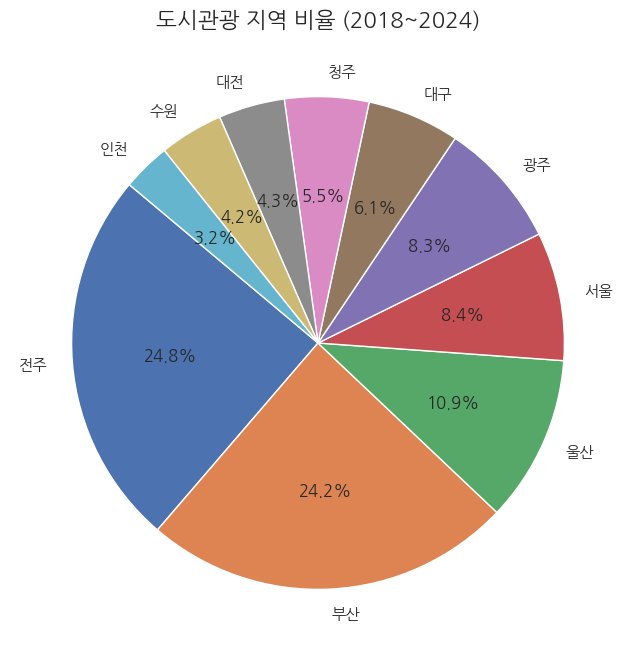

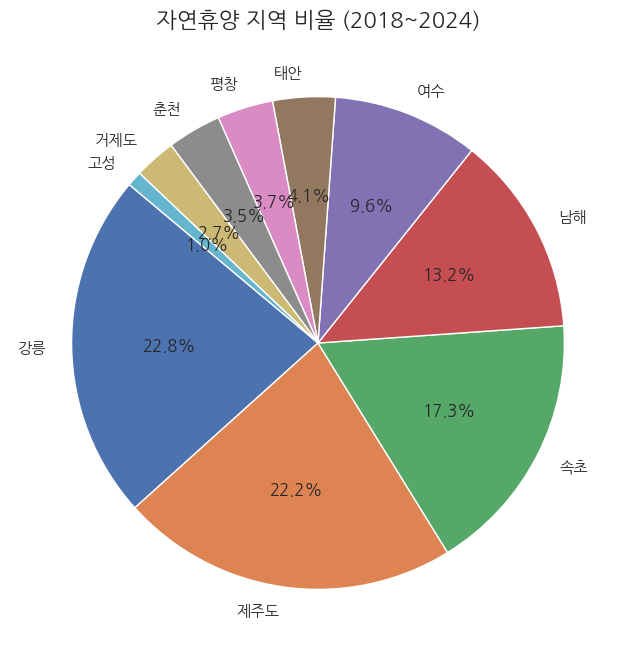

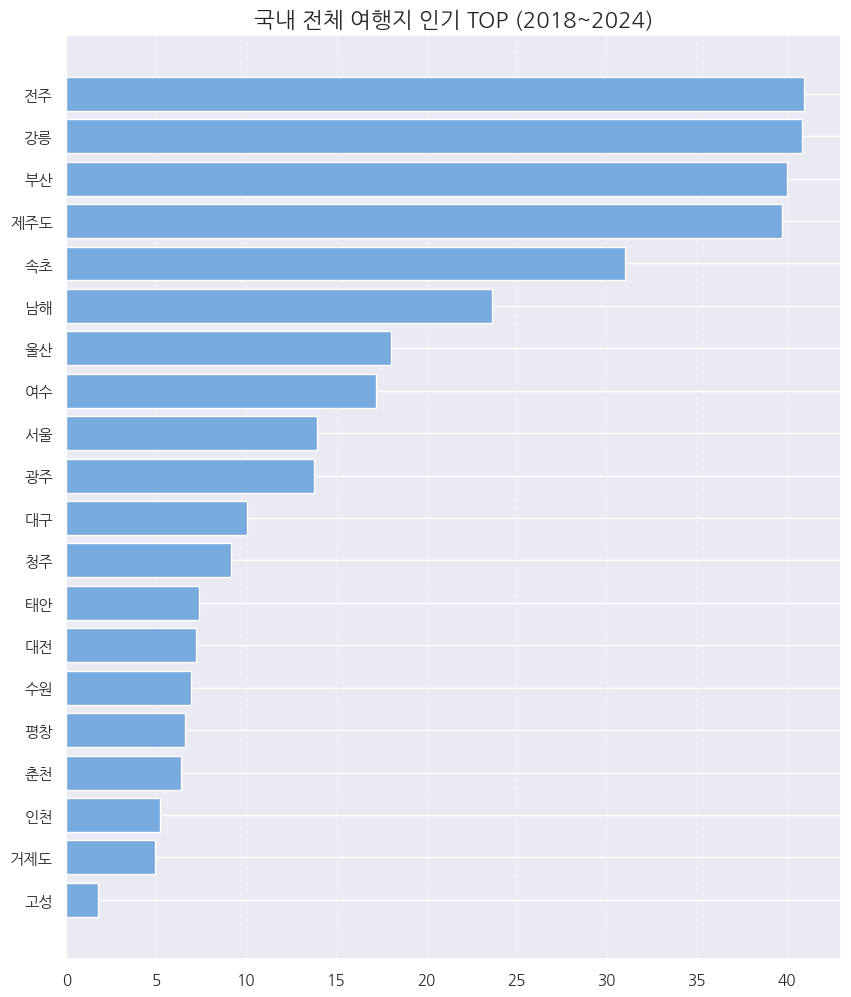

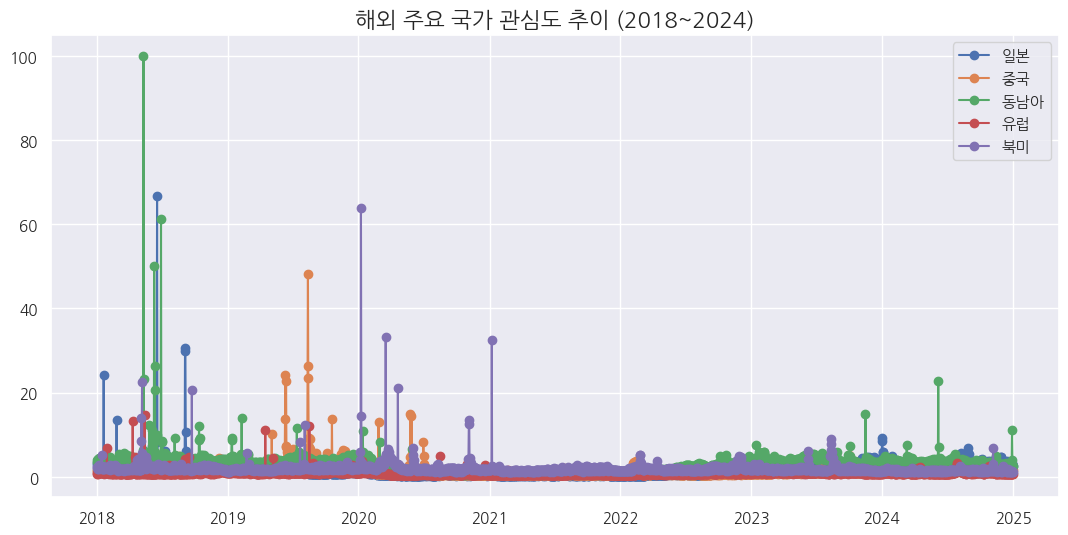

In [10]:
# ================================================================
# 9) 시각화 (지역/성별/연령/유형/코로나)
# ================================================================
# 도시관광
city_mean = df_city_all.groupby("region")["ratio"].mean().sort_values(ascending=False)
plot_pie("도시관광 지역 비율 (2018~2024)", city_mean)

# 자연휴양
nat_mean = df_nat_all.groupby("region")["ratio"].mean().sort_values(ascending=False)
plot_pie("자연휴양 지역 비율 (2018~2024)", nat_mean)

# 전체 국내 지역
domestic_mean = df_domestic_region.groupby("region")["ratio"].mean().sort_values(ascending=False)
plot_region_bar(domestic_mean, "국내 전체 여행지 인기 TOP (2018~2024)")

# 해외 관심도 추이
plot_line(df_overseas_region, "date", "ratio", "region",
          "해외 주요 국가 관심도 추이 (2018~2024)")

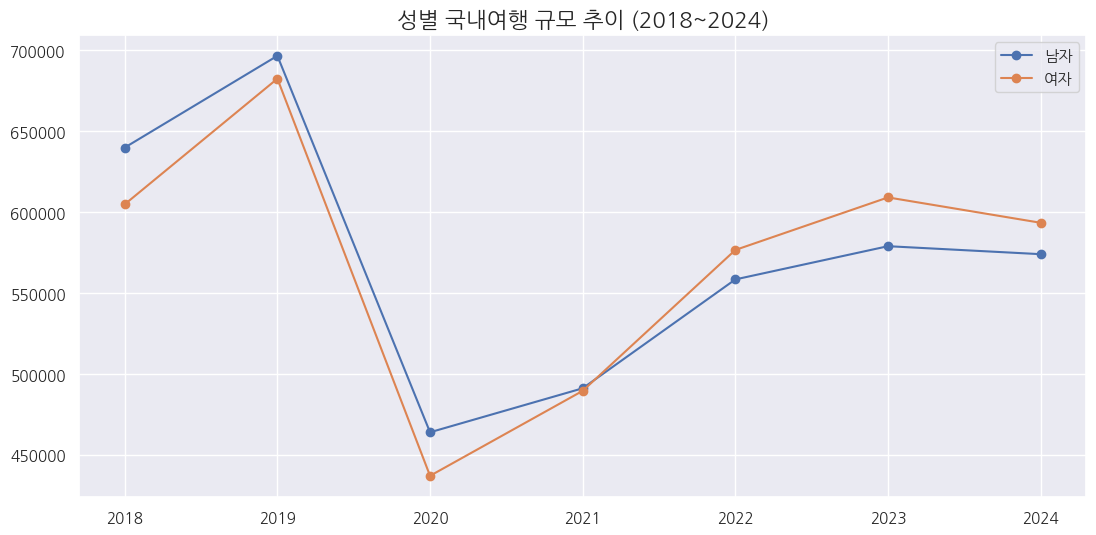

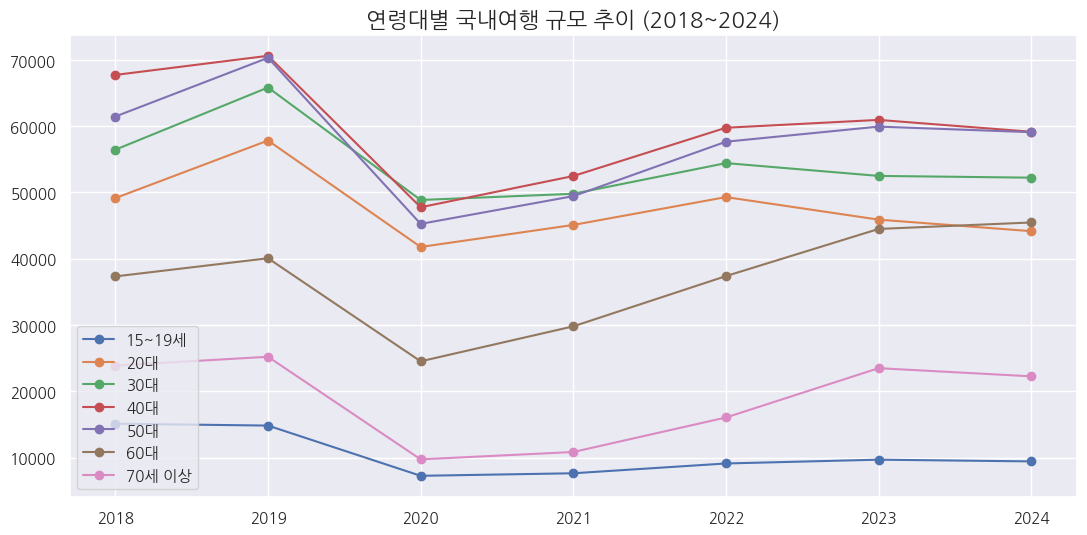

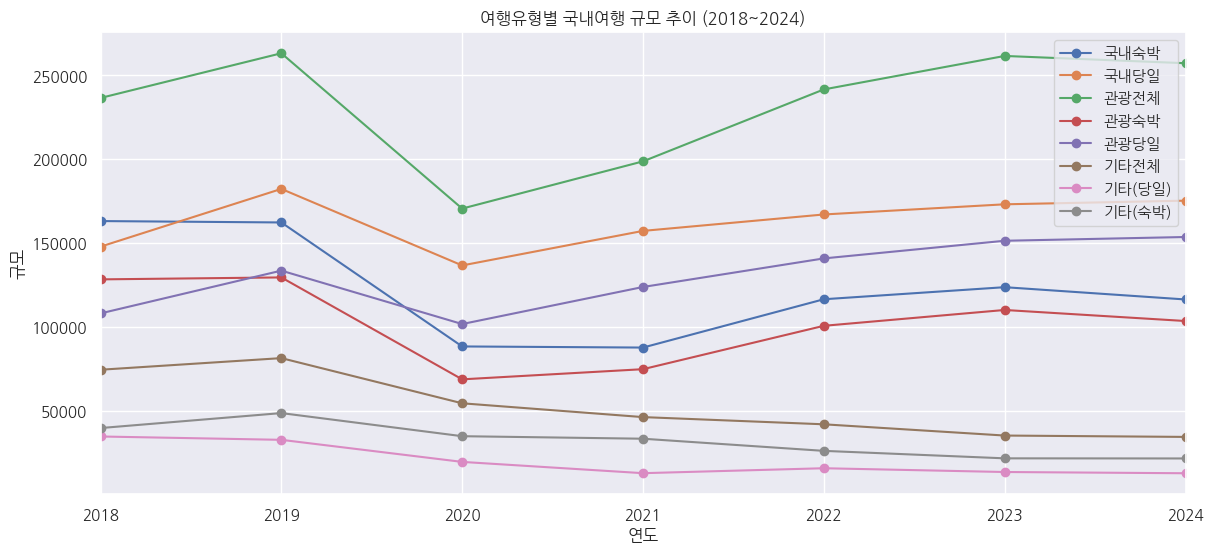

In [11]:
# ================================================================
# 10) 성별 / 연령 / 여행유형
# ================================================================
sex_all = df_long[df_long["sub_category"].isin(["남자","여자"])]
sex_year = sex_all.groupby(["sub_category","year"])["value"].sum().reset_index()
plot_line(sex_year, "year", "value", "sub_category",
          "성별 국내여행 규모 추이 (2018~2024)")

age_all = df_long[(df_long["category"]=="연령") & (df_long["type"]=="국내전체")]
plot_line(age_all, "year", "value", "sub_category",
          "연령대별 국내여행 규모 추이 (2018~2024)")

type_all = df_long[df_long["category"] == "전체"]

plt.figure(figsize=(14,6))

for t in type_all["type"].unique():
    if t != "국내전체":
        temp = type_all[type_all["type"] == t]
        plt.plot(temp["year"], temp["value"], marker="o", label=t)

plt.title("여행유형별 국내여행 규모 추이 (2018~2024)")
plt.xlabel("연도")
plt.ylabel("규모")
plt.legend()
plt.grid(True)
plt.xlim(2018, 2024)
plt.show()

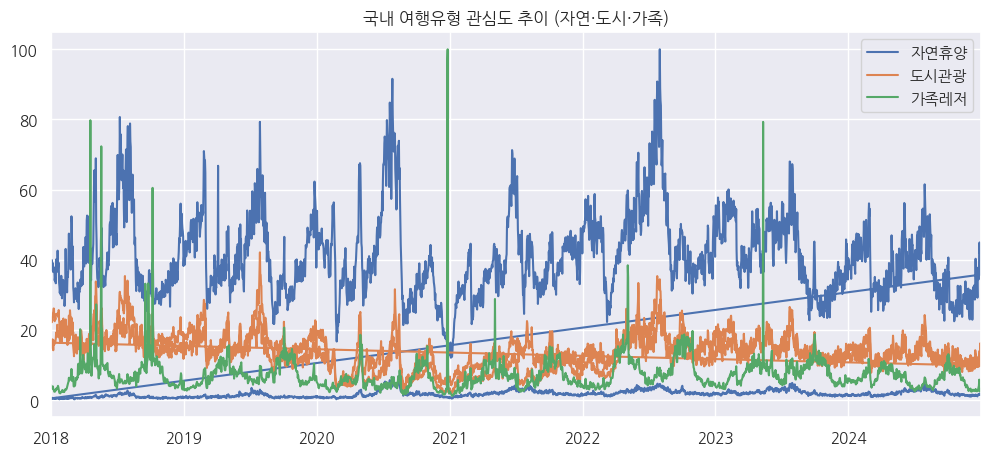

In [12]:
# ================================================================
# 📊 국내 여행유형 관심도 추이 (자연 · 도시 · 가족)
# ================================================================
plt.figure(figsize=(12,5))

for c in df_keywords["category"].unique():
    temp = df_keywords[df_keywords["category"] == c]
    plt.plot(temp["date"], temp["ratio"], label=c)

plt.title("국내 여행유형 관심도 추이 (자연·도시·가족)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xlim(df_keywords["date"].min(), pd.to_datetime("2024-12-31"))

plt.show()


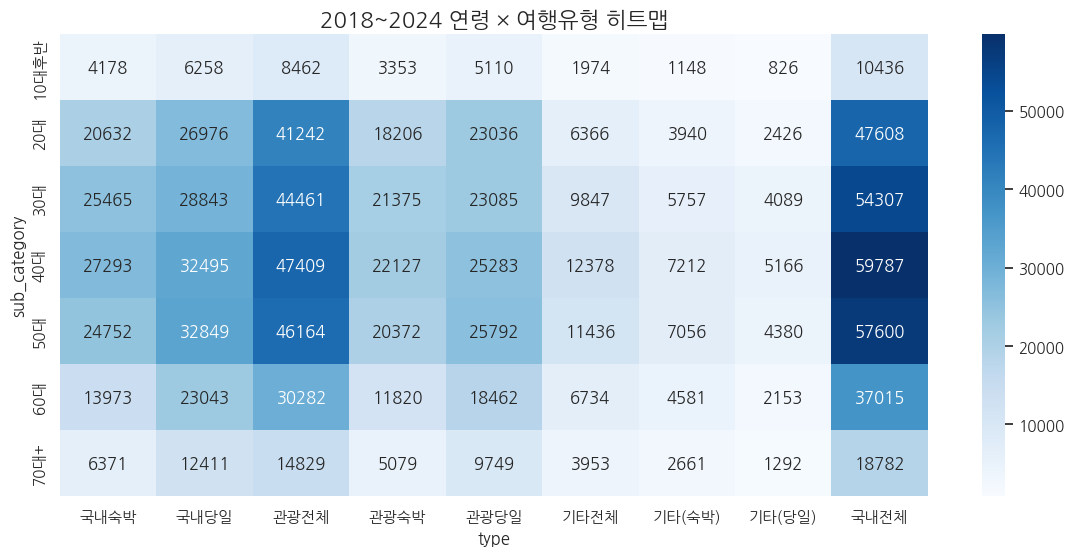

In [13]:
# ================================================================
# 11) 히트맵 (연령 × 유형)
# ================================================================
df_total = df_long[df_long["category"]=="연령"].copy()

age_label_map = {
    "15~19": "10대후반", "15~19세":"10대후반",
    "20대":"20대","30대":"30대","40대":"40대",
    "50대":"50대","60대":"60대","70세 이상":"70대+"
}

df_total["sub_category"] = df_total["sub_category"].astype(str).replace(age_label_map)
df_total["value"] = df_total["value"].astype(str).str.replace(",","").str.replace(" ","")
df_total["value"] = pd.to_numeric(df_total["value"], errors="coerce").fillna(0)

type_map = {
    '1': "국내숙박",'2':"국내당일",'3':"관광전체",
    '4': "관광숙박",'5':"관광당일",'6':"기타전체",
    '7': "기타(당일)",'8':"기타(숙박)",'국내전체':"국내전체"
}
df_total["type"] = df_total["type"].astype(str).replace(type_map)

pivot_total = df_total.pivot_table(
    index="sub_category", columns="type", values="value", aggfunc="mean"
)

age_order = ["10대후반","20대","30대","40대","50대","60대","70대+"]
type_order = ["국내숙박","국내당일","관광전체","관광숙박","관광당일",
              "기타전체","기타(숙박)","기타(당일)","국내전체"]

pivot_total = pivot_total.reindex(index=age_order, columns=type_order).fillna(0)

plt.figure(figsize=(14,6))
sns.heatmap(pivot_total, annot=True, fmt=".0f", cmap="Blues")
plt.title("2018~2024 연령 × 여행유형 히트맵", fontsize=16)
plt.show()


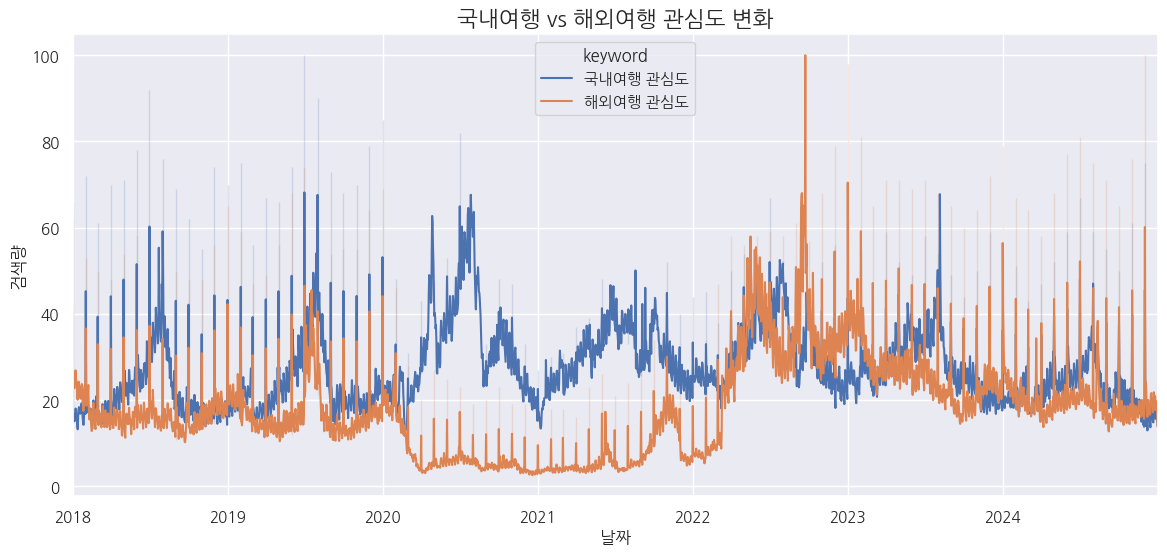

In [14]:
# ================================================================
# 📊 국내 vs 해외 여행 관심도 변화 (Google + Naver)
# ================================================================
df_plot = df_all[
    (df_all["keyword"].isin(["domestic", "overseas"])) &
    (df_all["source"].isin(["google", "naver"]))
].copy()

df_plot["keyword"] = df_plot["keyword"].replace({
    "domestic": "국내여행 관심도",
    "overseas": "해외여행 관심도"
})

plt.figure(figsize=(14,6))
sns.lineplot(data=df_plot, x="date", y="value", hue="keyword")
plt.title("국내여행 vs 해외여행 관심도 변화", fontsize=16)
plt.xlabel("날짜")
plt.ylabel("검색량")
plt.grid(True)

plt.xlim(df_plot["date"].min(), pd.to_datetime("2024-12-31"))

plt.show()


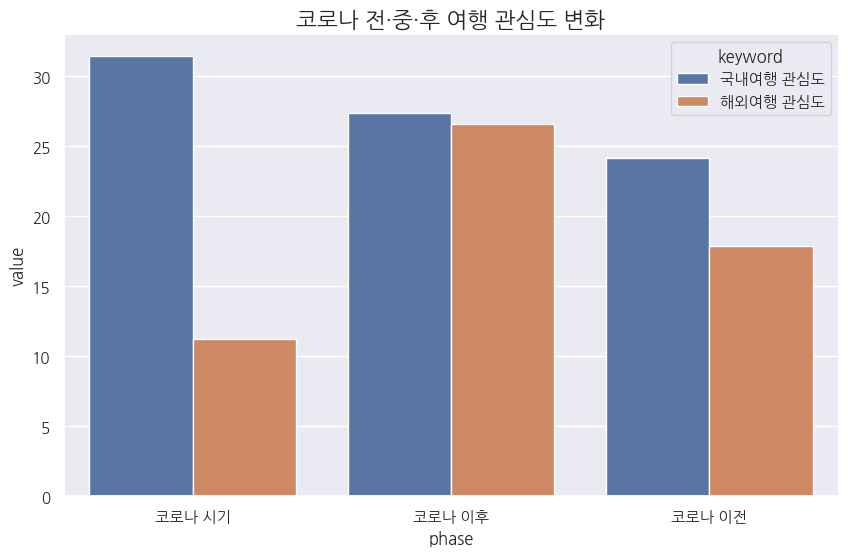

In [15]:
# ================================================================
# 12) 코로나 전·중·후 관심도 변화
# ================================================================
df_phase = df_all[(df_all["keyword"].isin(["domestic","overseas"])) &
                  (df_all["source"].isin(["google","naver"]))].copy()

df_phase["keyword"] = df_phase["keyword"].replace({
    "domestic":"국내여행 관심도",
    "overseas":"해외여행 관심도"
})

df_bar = df_phase.groupby(["phase","keyword"])["value"].mean().reset_index()
df_bar["phase"] = df_bar["phase"].replace({
    "pre":"코로나 이전", "mid":"코로나 시기", "post":"코로나 이후"
})

plt.figure(figsize=(10,6))
sns.barplot(data=df_bar, x="phase", y="value", hue="keyword")
plt.title("코로나 전·중·후 여행 관심도 변화", fontsize=16)
plt.show()


In [16]:
# ================================================================
# 📌 해외여행 관심도 vs 출국자수 상관관계 (Plotly)
# ================================================================
import plotly.express as px

# 해외여행 관심도 + 출국자수만 필터링
df_compare = df_all[df_all["keyword"].isin(["overseas", "departure"])]

# 날짜별 평균값으로 정리
df_clean = df_compare.groupby(["date", "keyword"])["value"].mean().reset_index()

# wide 형태로 변환
df_s = df_clean.pivot(index="date", columns="keyword", values="value").dropna()

# 한글 라벨 변경
df_s = df_s.rename(columns={
    "overseas": "해외여행 관심도",
    "departure": "출국자수"
})

# Plotly 시각화
fig = px.scatter(
    df_s,
    x="해외여행 관심도",
    y="출국자수",
    trendline="ols",
    title="해외여행 관심도 vs 출국자수 상관관계"
)

# 폰트 일관성 유지
fig.update_layout(
    font=dict(family="NanumGothic"),
    title_font=dict(size=22),
    xaxis_title_font=dict(size=16),
    yaxis_title_font=dict(size=16)
)

fig.update_traces(
    hovertemplate='관심도: %{x}<br>출국자수: %{y}'
)

fig.show()


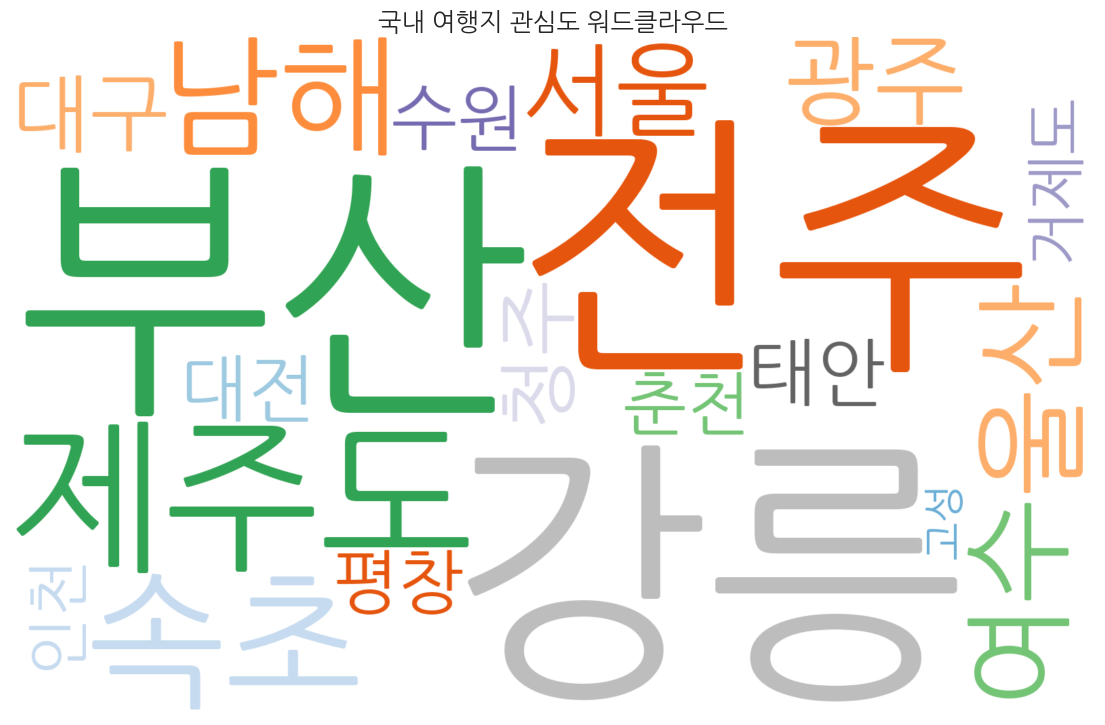

In [17]:
# ================================================================
# 13) 워드클라우드 (국내 지역)
# ================================================================
from wordcloud import WordCloud

df_region_all = df_domestic_region.copy()
region_mean = df_region_all.groupby("region")["ratio"].mean()

wc = WordCloud(
    font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
    background_color="white",
    colormap="tab20c",
    width=1600, height=1000
).generate_from_frequencies(region_mean.to_dict())

plt.figure(figsize=(14,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("국내 여행지 관심도 워드클라우드", fontsize=18)
plt.show()



   region  cluster
1     거제도        0
2      고성        0
6      대전        0
5      대구        0
13     인천        0
10     수원        0
17     춘천        0
16     청주        0
19     평창        0
18     태안        0
4      남해        1
9      속초        1
11     여수        2
12     울산        2
3      광주        2
8      서울        2
15    제주도        3
14     전주        3
0      강릉        3
7      부산        3


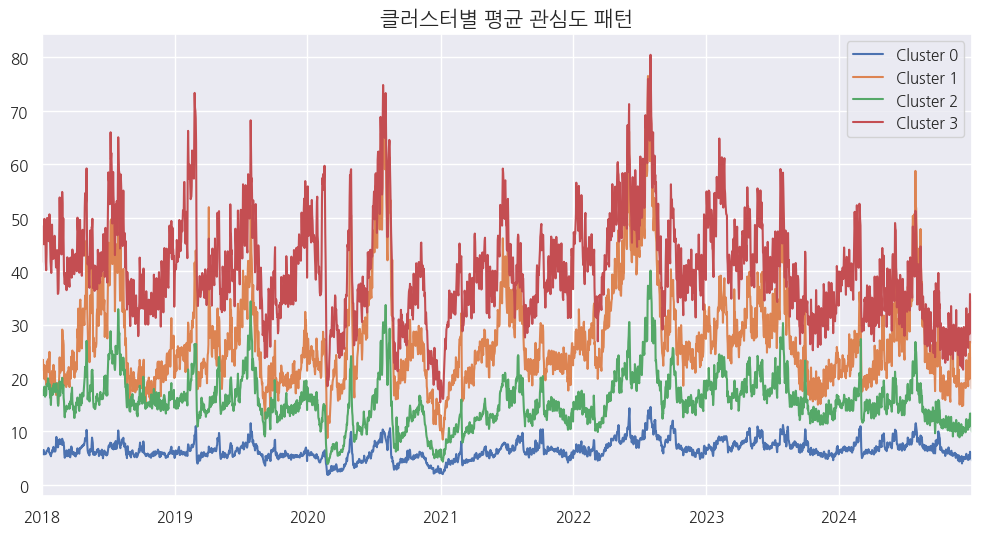

In [18]:
# ================================================================
# 14) KMeans 클러스터링
# ================================================================
pivot = df_region_all.pivot_table(index="date", columns="region", values="ratio").fillna(0)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(pivot.T)

clusters = pd.DataFrame({"region":pivot.columns, "cluster":labels})
print(clusters.sort_values("cluster"))

# 클러스터별 평균 패턴
plt.figure(figsize=(12,6))
for c in range(4):
    group = clusters[clusters["cluster"]==c]["region"]
    plt.plot(pivot[group].mean(axis=1), label=f"Cluster {c}")
plt.legend()
plt.title("클러스터별 평균 관심도 패턴", fontsize=15)
plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2024-12-31"))
plt.show()


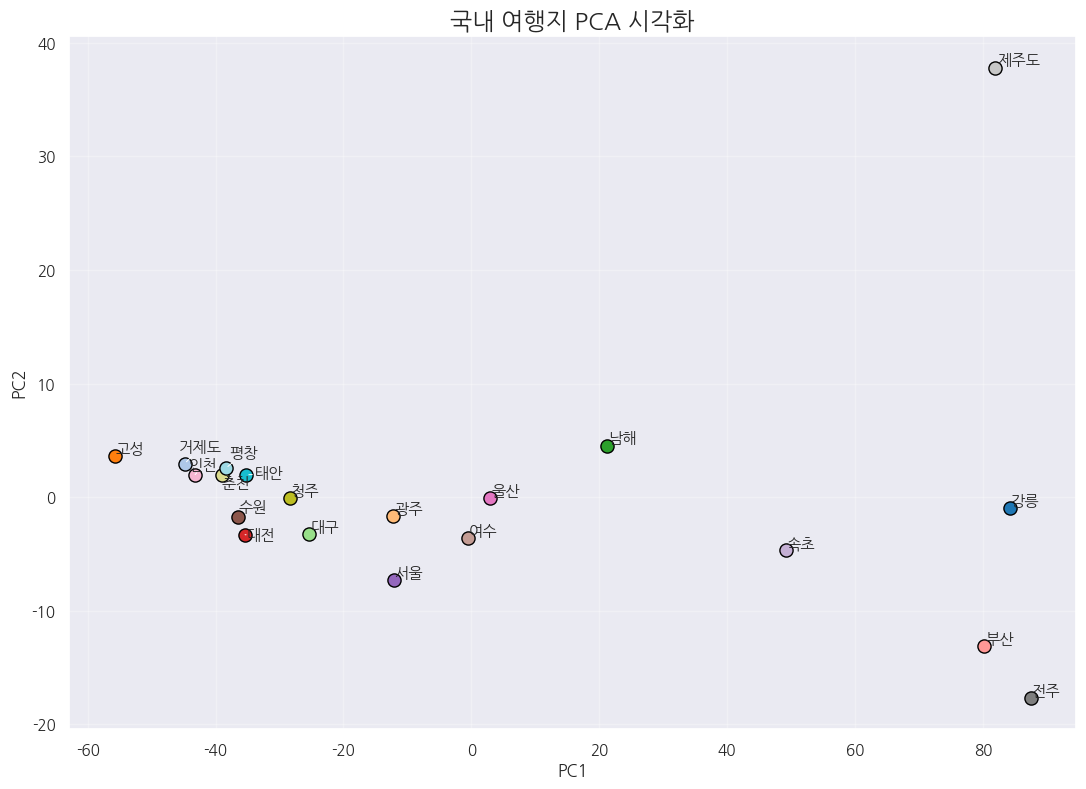

In [19]:
# ================================================================
# 15) PCA 분석
# ================================================================
!pip install adjustText

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text

pivot_region = pivot.copy()
X = pivot_region.T

scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)

pca_df = pd.DataFrame({
    "region": X.index,
    "PC1": pca_result[:,0],
    "PC2": pca_result[:,1]
})

plt.figure(figsize=(13,9))
colors = plt.cm.tab20.colors
texts = []

for i in range(len(pca_df)):
    plt.scatter(pca_df["PC1"][i], pca_df["PC2"][i],
                s=90, color=colors[i%20], edgecolor='black')
    texts.append(
        plt.text(pca_df["PC1"][i], pca_df["PC2"][i],
                 pca_df["region"][i], fontsize=11)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', lw=0.7))
plt.title("국내 여행지 PCA 시각화", fontsize=17)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(alpha=0.3)
plt.show()


In [20]:
# ================================================================
# 16) 지역 유사도 기반 추천
# ================================================================
from sklearn.metrics.pairwise import cosine_similarity

sim_df = pd.DataFrame(
    cosine_similarity(pivot_region.T),
    index=pivot_region.columns,
    columns=pivot_region.columns
)

def recommend_region(region, top=5):
    sims = sim_df.loc[region].sort_values(ascending=False)
    return sims.index[1:top+1]

print("인천 추천:", recommend_region("인천"))
print("강릉 추천:", recommend_region("강릉"))

인천 추천: Index(['강릉', '광주', '부산', '춘천', '울산'], dtype='object', name='region')
강릉 추천: Index(['속초', '인천', '부산', '울산', '여수'], dtype='object', name='region')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


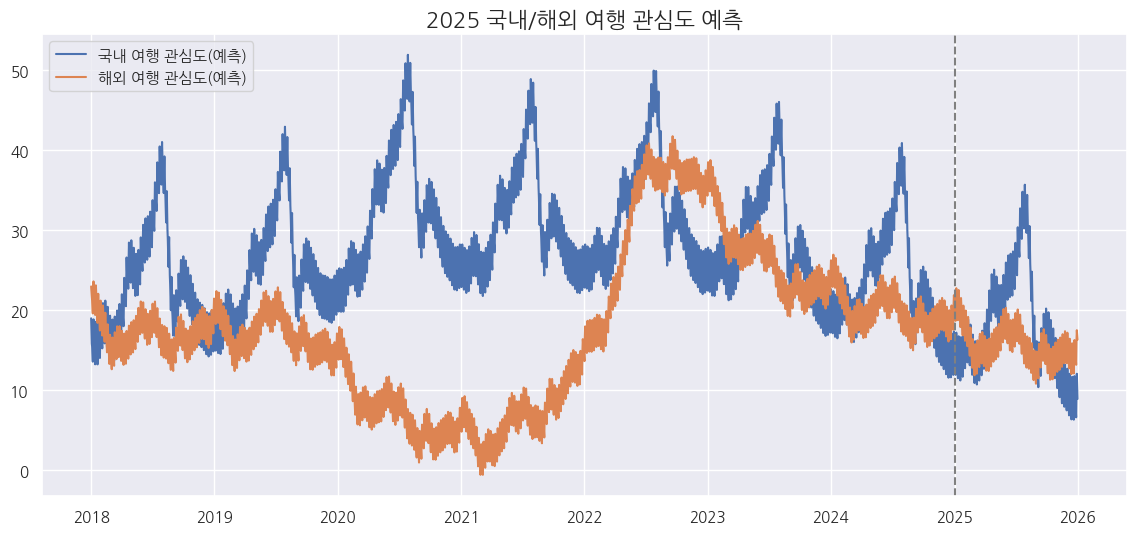

In [21]:
# ================================================================
# 17) Prophet 기반 2025 예측
# ================================================================
from prophet import Prophet

def forecast_prophet(df, periods=365):
    m = Prophet(yearly_seasonality=True)
    m.fit(df)
    future = m.make_future_dataframe(periods=periods)
    fc = m.predict(future)
    return m, fc

# 국내
dom_ts = df_all[df_all["keyword"]=="domestic"].groupby("date")["value"].mean().reset_index()
dom_ts = dom_ts.rename(columns={"date":"ds","value":"y"})

# 해외
over_ts = df_all[df_all["keyword"]=="overseas"].groupby("date")["value"].mean().reset_index()
over_ts = over_ts.rename(columns={"date":"ds","value":"y"})

model_dom, fc_dom = forecast_prophet(dom_ts)
model_over, fc_over = forecast_prophet(over_ts)

plt.figure(figsize=(14,6))
plt.plot(fc_dom["ds"], fc_dom["yhat"], label="국내 여행 관심도(예측)")
plt.plot(fc_over["ds"], fc_over["yhat"], label="해외 여행 관심도(예측)")
plt.axvline(pd.to_datetime("2025-01-01"), color="gray", linestyle="--")
plt.title("2025 국내/해외 여행 관심도 예측", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()